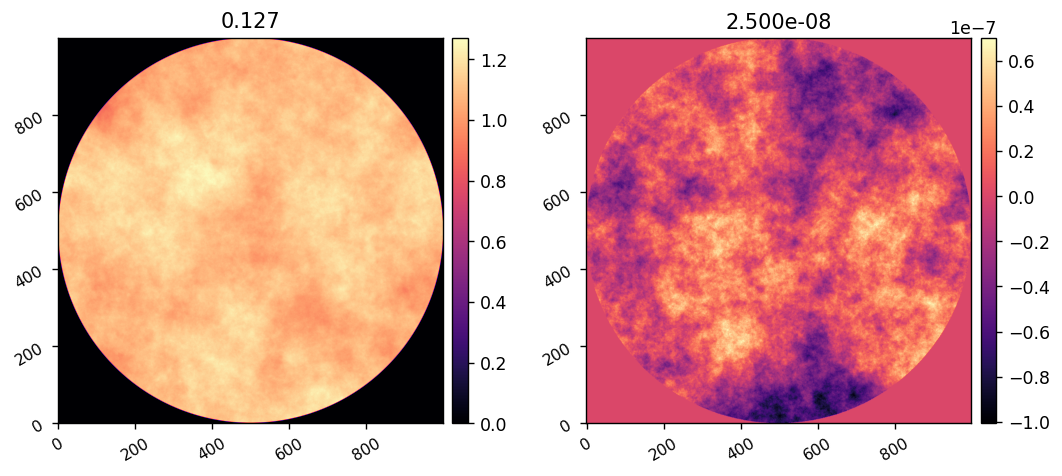

array(2.5e-08)

In [2]:

import numpy as np
import astropy.units as u
from datetime import datetime
today = int(datetime.today().strftime('%Y%m%d'))
from importlib import reload

from matplotlib.patches import Circle

import scoobpsf
import scoobpsf.utils as utils
from scoobpsf.math_module import xp, _scipy, ensure_np_array
from scoobpsf.imshows import imshow1, imshow2, imshow3
import scoobpsf.compact_scoob_2 as cscoob
import scoobpsf.dm as dm

import lina

npsf = 200

wavelength = 633*u.nm
pupil_diam = 6.75*u.mm

reload(utils)
npix = 1000
WFE, mask = utils.generate_wfe(diam=pupil_diam,
                                npix=npix, oversample=1,
                                wavelength=wavelength,
                                opd_index=2.75, amp_index=3,
                                opd_rms=25*u.nm, amp_rms=0.05,
                                remove_modes=12)

wfe_amp = xp.abs(WFE)
wfe_opd = xp.angle(WFE)*wavelength.to_value(u.m)/2/np.pi
rms_amp = xp.sqrt(xp.mean(xp.square(wfe_amp[mask]-1)))
rms_opd = xp.sqrt(xp.mean(xp.square(wfe_opd[mask])))
imshow2(wfe_amp, wfe_opd,  f'{rms_amp:.3f}', f'{rms_opd:.3e}')
lina.utils.rms(wfe_opd[mask])



influence function sampling 31.914893617021274
Using the influence function supplied.
Including factor of 2 from reflection when computing OPD.


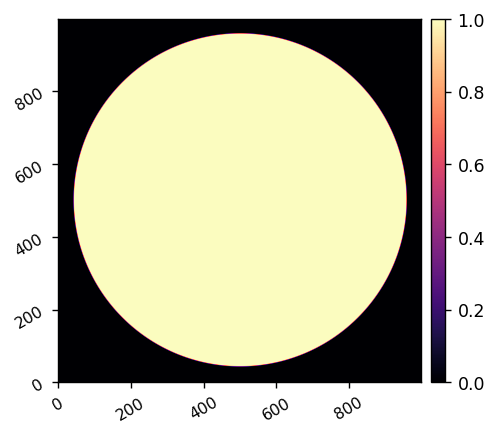

influence function sampling 31.914893617021274
Using the influence function supplied.
Including factor of 2 from reflection when computing OPD.


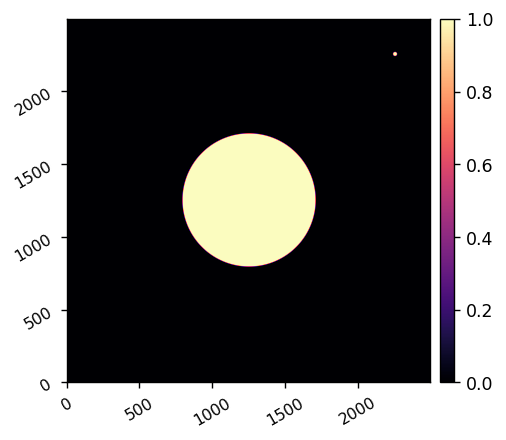

influence function sampling 31.914893617021274
Using the influence function supplied.
Including factor of 2 from reflection when computing OPD.


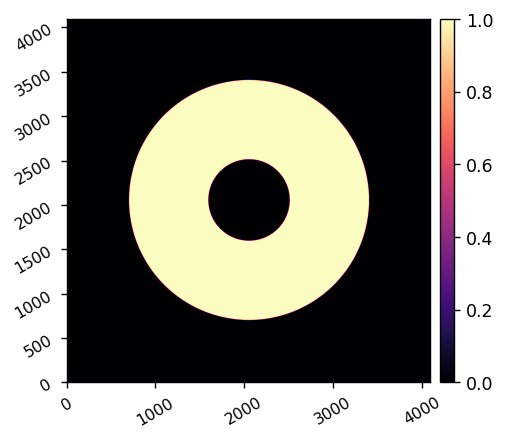

In [3]:
model = cscoob.CORO()
imshow1(model.LYOT)
model = cscoob.CORO(use_scc=True)
imshow1(model.LYOT)
model = cscoob.CORO(use_scc=True, use_llowfsc=True)
imshow1(model.LYOT)

influence function sampling 31.914893617021274
Using the influence function supplied.
Including factor of 2 from reflection when computing OPD.


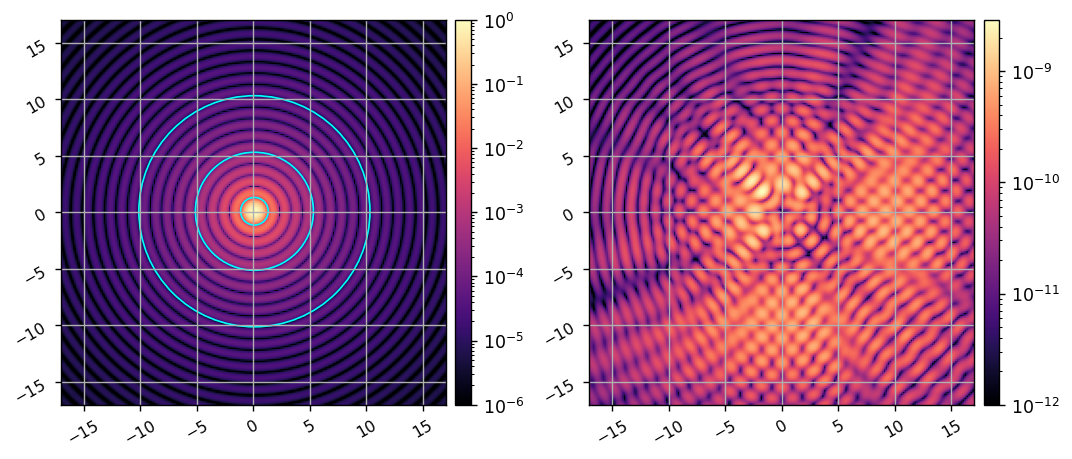

In [4]:
reload(cscoob)
reload(scoobpsf.props)
model = cscoob.CORO()
# model = cscoob.CORO(use_fieldstop=True)
# model = cscoob.CORO(use_scc=True)
# model = cscoob.CORO(use_scc=True, use_fieldstop=True)

# model.WFE = WFE
ref_psf = model.snap()
model.Imax_ref = xp.max(ref_psf)

# model.Nfpm = 8192*2

pup_ratio = model.dm_pupil_diam.to_value(u.m)/model.dm_active_diam.to_value(u.m)
xpp = (xp.arange(-model.Nact//2, model.Nact//2) + 1/2)/pup_ratio
ppx, ppy = xp.meshgrid(xpp,xpp)
amp = 5e-8
separation = 10
comm1 = amp*xp.cos(2*np.pi*(ppx + ppy)*separation/model.Nact)*xp.array(model.dm_mask)
comm2 = amp*xp.cos(2*np.pi*(ppx - ppy)*separation/model.Nact)*xp.array(model.dm_mask)
# model.set_dm(comm1+comm2)

model.use_fpm = True

wfs = model.calc_wfs()
im = xp.abs(wfs[-1])**2

imshow2(ref_psf/model.Imax_ref, im, lognorm=True, vmin1=1e-6, vmin2=1e-12,
        pxscl=model.psf_pixelscale_lamD, grid=True, 
        patches1=[Circle((model.psf_pixelscale_lamD/2,model.psf_pixelscale_lamD/2), 1.22, fill=False, color='cyan'),
                  Circle((model.psf_pixelscale_lamD/2,model.psf_pixelscale_lamD/2), 1.22+4, fill=False, color='cyan'),
                  Circle((model.psf_pixelscale_lamD/2,model.psf_pixelscale_lamD/2), 1.22+9, fill=False, color='cyan')])

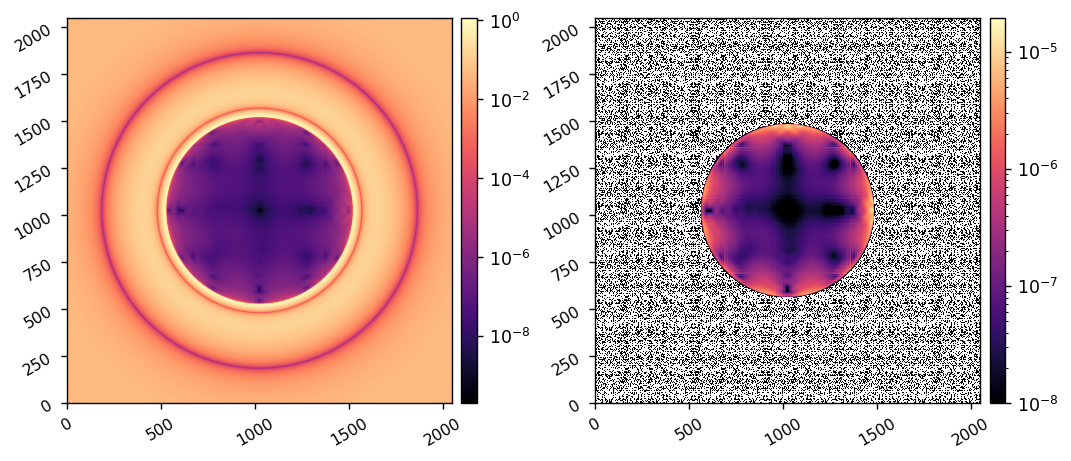

In [5]:
imshow2(xp.abs(wfs[-3])**2, xp.abs(wfs[-2])**2, lognorm=True, vmin1=2e-10, vmin2=1e-8)

influence function sampling 31.914893617021274
Using the influence function supplied.
Including factor of 2 from reflection when computing OPD.


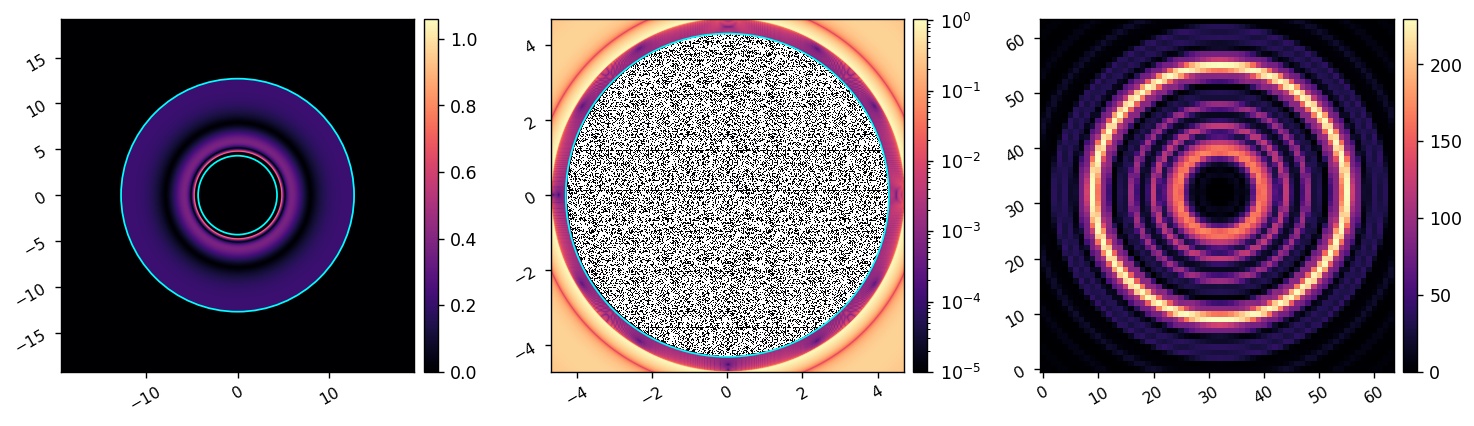

In [6]:
model = cscoob.CORO(use_scc=True, use_llowfsc=True)
model.llowfsc_fl = 200*u.mm
model.use_fpm = True

wfs = model.calc_wfs()
im = xp.abs(wfs[-1])**2

imshow3(xp.abs(wfs[-2]), xp.abs(wfs[-2]), im, npix2=model.npix, lognorm2=True, vmin2=1e-5, 
        pxscl1=model.lyot_pupil_diam/model.npix, pxscl2=model.lyot_pupil_diam/model.npix,
        patches1=[Circle((0,0), 8.6/2, fill=False, color='cyan'),
                  Circle((0,0), 25.4/2, fill=False, color='cyan'),],
        patches2=[Circle((0,0), 8.6/2, fill=False, color='cyan'),],
                  )

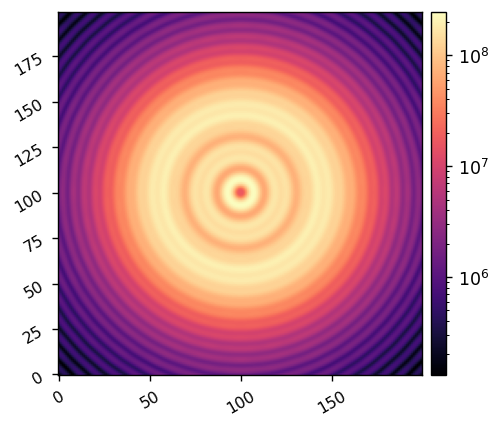

In [3]:
defocus = 2e-3*oversample**2
fnum = 200/8.6
tf = props.get_fresnel_TF(defocus, wfe.shape[0], wavelength.to_value(u.m), fnum)
image = xp.abs(props.mft_forward(tf*mask, psf_pixelscale_lamD*oversample))**2
imshow1(image, lognorm=True)